## Stock market prediction

In [93]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
%matplotlib inline
import math
import statsmodels.api as sm
import talib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [94]:
# import SPY 10 years of data to the most recent date in 2021. 
# SPY is designed to track the S&P 500 stock market index. This fund is the largest ETF in the world. 
df = web.DataReader('SPY', data_source='yahoo', start='2010-01-01', end='2021-02-19')

## Exporatory Data Analysis

In [95]:
df.tail() # examine the stock data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-12,392.899994,389.769989,389.850006,392.640015,50505700.0,392.640015
2021-02-16,394.170013,391.529999,393.959991,392.299988,50700800.0,392.299988
2021-02-17,392.660004,389.329987,390.420013,392.390015,52290600.0,392.390015
2021-02-18,391.519989,387.739990,389.589996,390.720001,59552200.0,390.720001
2021-02-19,392.380005,389.549988,392.070007,390.029999,83142800.0,390.029999


In [96]:
df.shape # get the number of rows and columns

(2802, 6)

In [97]:
df.describe() # generate descriptive statistics

,High,Low,Open,Close,Volume,Adj Close
count,2802.000000,2802.000000,2802.000000,2802.000000,2.802000e+03,2802.000000
mean,210.783105,208.517659,209.704789,209.734333,1.237649e+08,192.583213
std,69.809154,69.075299,69.468840,69.454677,7.465493e+07,75.348641
min,103.419998,101.129997,103.110001,102.199997,2.027000e+07,82.872505
25%,142.442497,141.355003,141.982498,141.982498,7.239802e+07,120.491968
50%,206.800003,204.629997,205.614998,205.614998,1.038480e+08,184.856987
75%,268.587502,265.575005,267.577507,267.287506,1.530642e+08,254.170013
max,394.170013,391.529999,393.959991,392.640015,7.178287e+08,392.640015


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2802 entries, 2010-01-04 to 2021-02-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2802 non-null   float64
 1   Low        2802 non-null   float64
 2   Open       2802 non-null   float64
 3   Close      2802 non-null   float64
 4   Volume     2802 non-null   float64
 5   Adj Close  2802 non-null   float64
dtypes: float64(6)
memory usage: 153.2 KB


In [99]:
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2021-02-05', '2021-02-08', '2021-02-09', '2021-02-10',
               '2021-02-11', '2021-02-12', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19'],
              dtype='datetime64[ns]', name='Date', length=2802, freq=None)

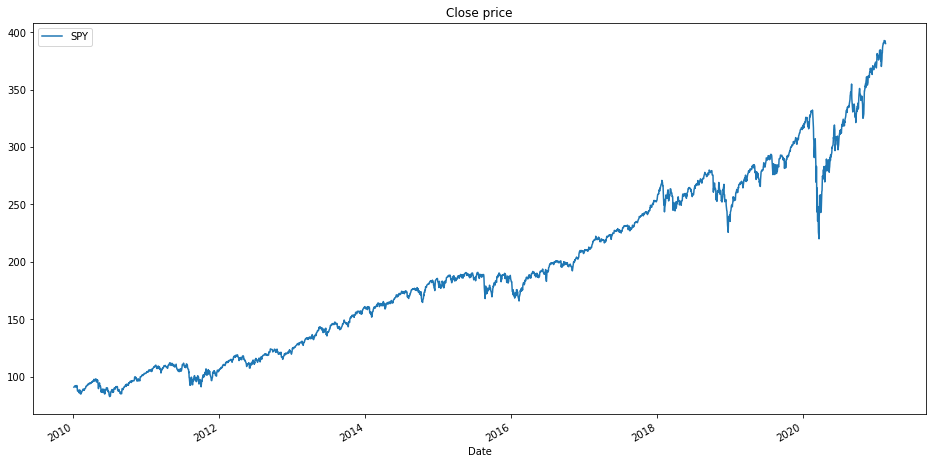

In [100]:
# plot the closing price
df['Adj Close'].plot(label='SPY', figsize=(16,8), title='Close price')
plt.legend();

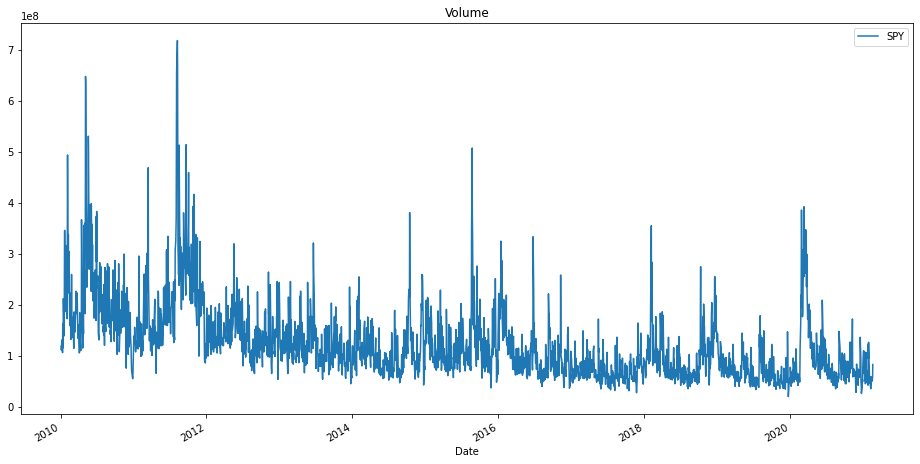

In [101]:
# plot the volume
df['Volume'].plot(label='SPY', figsize=(16,8), title='Volume')
plt.legend();

#### SPY has a huge volume in 2011. Let's find out the exact date of this event to see what happend that date

In [102]:
df['Volume'].idxmax()

Timestamp('2011-08-09 00:00:00')

#### The event was on Black Monday when US and global stock markets crashed.

<AxesSubplot:xlabel='Date'>

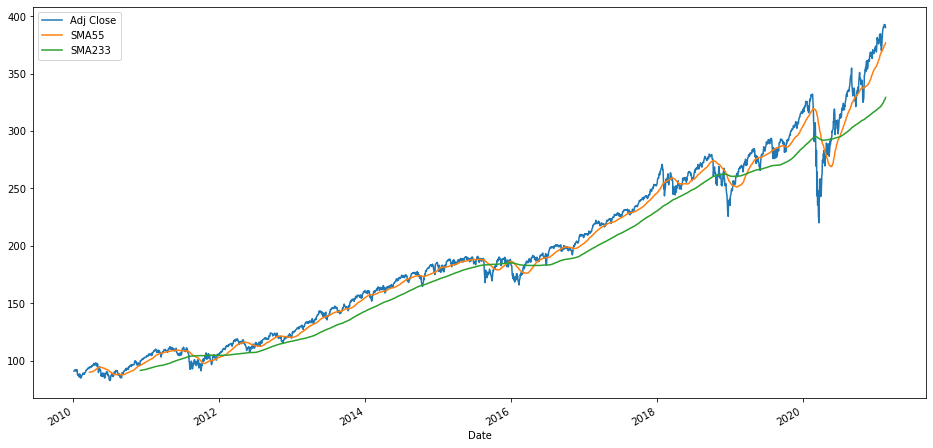

In [103]:
# plot the simple moving average (SMA)
df['SMA55'] = df['Adj Close'].rolling(55).mean()
df['SMA233'] = df['Adj Close'].rolling(233).mean()
df[['Adj Close', 'SMA55', 'SMA233']].plot(figsize=(16,8))

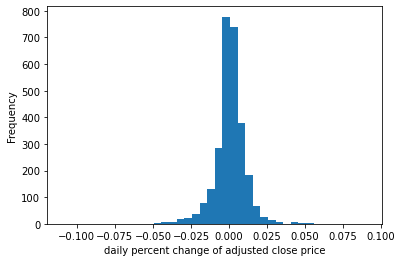

In [104]:
# histogram of the daily price change percent of the closing price
df['Adj Close'].pct_change().plot.hist(bins=40)
plt.xlabel('daily percent change of adjusted close price')
plt.show()

## Correlation coefficient
#### Check how strong is the correlation of previous price changes vs future price changes. If it's highly correlated, then the stock price is trend following. Otherwise, the stock price is mean-reverting.

            Current Adj Close Percent  Future Adj Close Percent
Date                                                           
2010-01-04                        NaN                       NaN
2010-01-05                        NaN                       NaN
2010-01-06                        NaN                       NaN
2010-01-07                        NaN                       NaN
2010-01-08                        NaN                       NaN
...                               ...                       ...
2021-02-12                   0.025491                  0.053936
2021-02-16                   0.020578                  0.036680
2021-02-17                   0.022408                  0.022225
2021-02-18                   0.043562                  0.021422
2021-02-19                   0.032836                  0.009943

[2802 rows x 2 columns]


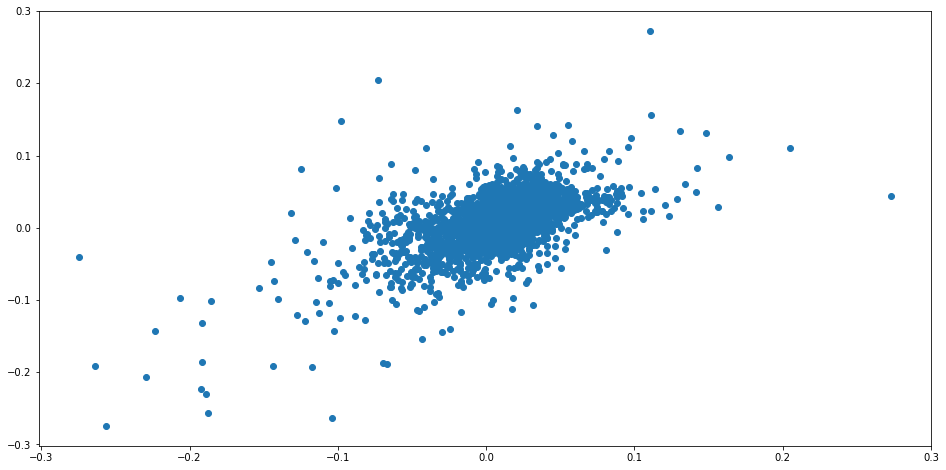

In [105]:
trading_period = 15 # define the trading period to calculate the correlation

df['Future Adj Close'] = df['Adj Close'].shift(-5) # create a new future price of the next 5 trading days
df['Future Adj Close Percent'] = df['Future Adj Close'].pct_change(trading_period) # Future price change percentage
df['Current Adj Close Percent'] = df['Adj Close'].pct_change(trading_period) # Current price change percentage

corr = df[['Current Adj Close Percent', 'Future Adj Close Percent']]
print(corr)

# plot the correlation
plt.figure(figsize=(16,8))
plt.scatter(df['Current Adj Close Percent'], df['Future Adj Close Percent'])

In [106]:
df['Current Adj Close Percent']

Date
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
                ...   
2021-02-12    0.025491
2021-02-16    0.020578
2021-02-17    0.022408
2021-02-18    0.043562
2021-02-19    0.032836
Name: Current Adj Close Percent, Length: 2802, dtype: float64

#### We can see the future price change is negatively correlated to the previous price change for a 5 days trading period. This tells us that a mean reversion trading would be a good trading strategy.

## Feature Engineering
#### We want to add more data to the machinee learning models to make better prediction. We will add the new features below:

#### 1. Adding  simple moving averages and RSI (Relative Strength Index) for different time period

In [107]:
new_features = ['Current Adj Close Percent']

# time preiods using numbers in the Fibonacci Sequence
# time_periods = [55, 89, 144, 233] 
time_periods = [21, 89, 377, 1597] # Tried different time periods to get better correlations between the features and targets in the steps below

for n in time_periods:

    # Create the moving average indicator and divide by Adj_Close
    df['sma' + str(n)] = talib.SMA(df['Adj Close'].values,
                              timeperiod=n) / df['Adj Close']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    new_features = new_features + ['sma' + str(n), 'rsi' + str(n)]

print(new_features)

['Current Adj Close Percent', 'sma21', 'rsi21', 'sma89', 'rsi89', 'sma377', 'rsi377', 'sma1597', 'rsi1597']


In [108]:
df = df.dropna()
features = df[new_features]
targets = df['Future Adj Close Percent']

# create a new DataFrame from the target column and the new features columns
cols = ['Future Adj Close Percent'] + new_features
new_df = df[cols]

# Calculate correlation matrix
corr = new_df.corr()
print(corr)

                           Future Adj Close Percent  \
Future Adj Close Percent                   1.000000   
Current Adj Close Percent                  0.648052   
sma21                                     -0.720765   
rsi21                                      0.428487   
sma89                                     -0.329875   
rsi89                                      0.209606   
sma377                                    -0.187295   
rsi377                                     0.068950   
sma1597                                   -0.147491   
rsi1597                                    0.011087   

                           Current Adj Close Percent     sma21     rsi21  \
Future Adj Close Percent                    0.648052 -0.720765  0.428487   
Current Adj Close Percent                   1.000000 -0.930232  0.623767   
sma21                                      -0.930232  1.000000 -0.661024   
rsi21                                       0.623767 -0.661024  1.000000   
sma89         

<AxesSubplot:>

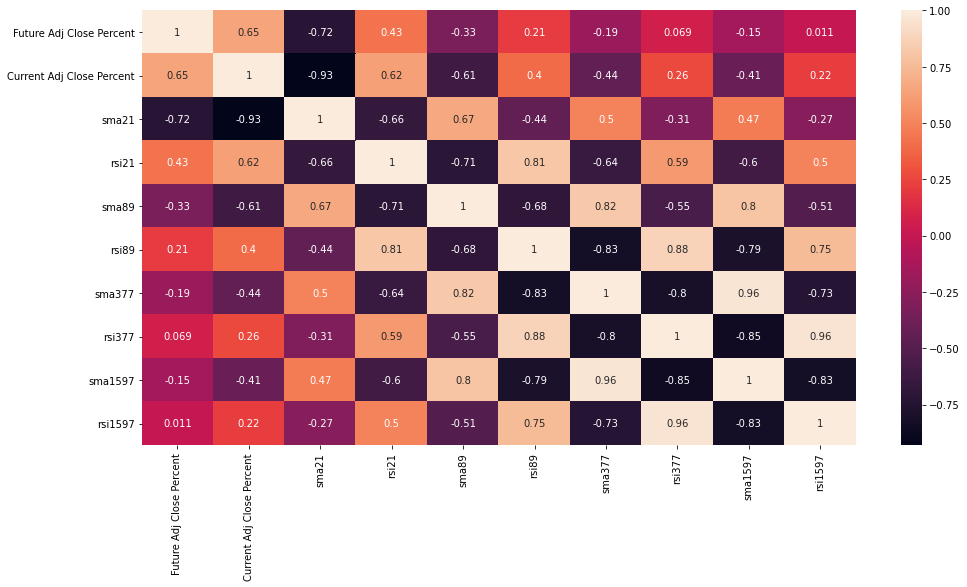

In [109]:
# plot the heatmap to see the correlations between the features and targets
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr, annot=True, ax=ax)

In [110]:
features.shape

(1200, 9)

#### 2. Adding a simple moving average (SMA) which is one of the most common indicators.

<AxesSubplot:ylabel='Frequency'>

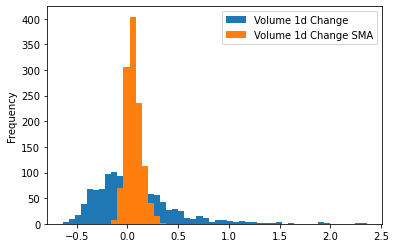

In [111]:
volume_features = ['Volume 1d Change', 'Volume 1d Change SMA']
new_features.extend(volume_features)

# new feature - volumne change percentage in 1 day
df['Volume 1d Change'] = df['Volume'].pct_change(1)

# new feature - 8 day moving average of the 1 day percent change in volume
df['Volume 1d Change SMA'] = talib.SMA(df['Volume 1d Change'].values, timeperiod=8)

df[volume_features].plot(kind='hist', sharex=False, bins=50)

#### 3. Adding a day of the week feature

In [112]:
# Create train and test set
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
# Use 75% of the total samples for the training set
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.25, random_state = 0)

print(features.shape, X_train.shape, X_test.shape)

(1200, 9) (900, 9) (300, 9)


In [113]:
days_of_week = pd.get_dummies(df.index.dayofweek,
                             prefix='Day of Week',
                             drop_first=True)

days_of_week.index = df.index
# join the data frame
df = pd.concat([df, days_of_week], axis=1)

# add days of week to the list of new features
new_features.extend(['Day of Week_' + str(n) for n in range(1, 5)] )
# drop missing value
df.dropna(inplace=True)

df.head()


,High,Low,Open,Close,Volume,Adj Close,SMA55,SMA233,Future Adj Close,Future Adj Close Percent,...,sma377,rsi377,sma1597,rsi1597,Volume 1d Change,Volume 1d Change SMA,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-19,204.539993,202.779999,204.059998,204.199997,115430500.0,186.357086,187.145827,183.055119,191.047989,0.021320,...,0.986314,52.013592,0.741214,53.192354,-0.038577,0.070260,0,0,1,0
2016-05-20,206.100006,204.860001,204.919998,205.490005,104990400.0,187.534409,187.257584,183.043980,191.869370,0.021972,...,0.980207,52.145731,0.736882,53.229469,-0.090445,0.053749,0,0,0,1
2016-05-23,205.839996,204.990005,205.509995,205.210007,58682600.0,187.278870,187.353964,183.035366,191.504318,0.019185,...,0.981621,52.114500,0.738204,53.220304,-0.441067,-0.008249,0,0,0,0
2016-05-24,208.240005,206.139999,206.169998,207.869995,93537800.0,189.706421,187.491840,183.033009,191.896759,0.008731,...,0.969155,52.386123,0.729082,53.296742,0.593961,0.053975,1,0,0,0
2016-05-25,209.770004,207.869995,208.669998,209.279999,76621400.0,190.993210,187.689264,183.035596,192.480804,0.021356,...,0.962732,52.529237,0.724502,53.337185,-0.180851,0.021758,0,1,0,0


## Correlation coefficient of the new features

#### Check how strong is the correlation of the new features with the target "Future Close Percent" feature

<AxesSubplot:>

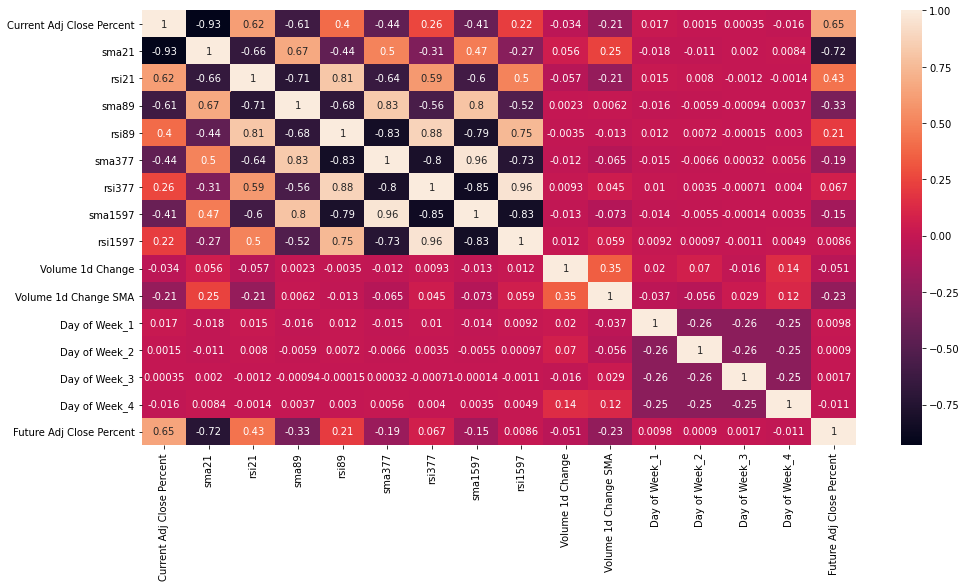

In [114]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(df[new_features + ['Future Adj Close Percent']].corr(), annot=True, ax=ax)

#### We can see the correlations is very weak so the new features won't help the model. We will use the default features with the Adj Close instead

In [115]:
df = web.DataReader('SPY', data_source='yahoo', start='2010-01-01', end='2021-02-19')
data = df.filter(['Adj Close'])
# Convert the dataframe to a numpy array
data = data.values

train_data_len = math.ceil(len(data) * 0.75)
train_data_len

2102

In [116]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [117]:
# Create the train data set
# With financial time series data, we want to use previous day data to make prediction on the next day.
# This would help us to validate the model performance on the most recent stock price.

train_data = scaled_data[0:train_data_len, :]
# Split to X_train and y_train dataset
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
# Convert x_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [118]:
# Create the test data set
test_data = scaled_data[train_data_len - 60:, :] 
# Split to X_test and y_test dataset
X_test = []
y_test = data[train_data_len:, :]

for i in range (60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
# Convert X_test to a numpy array
X_test = np.array(X_test)

In [128]:
# Reshaping the train data to 3 dimensional data shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

# Reshaping the test data to 3 dimensional data shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(2042, 60, 1)
(700, 60, 1)


## 1st Neural Network Model

In [29]:
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam, RMSprop

optimizer = Adam(learning_rate=0.0001)

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

set_seeds()

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
#model.add(Dropout(0.2)) # add dropout to prevent overfitting
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# fit the neural network model with a mean squared error loss function
model_1.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
history = model_1.fit(X_train, y_train, epochs=100, batch_size=30)

Epoch 1/100
2042/2042 [==============================] - 19s 9ms/step - loss: 0.0475 - accuracy: 4.8972e-04
Epoch 2/100
2042/2042 [==============================] - 18s 9ms/step - loss: 0.0018 - accuracy: 4.8972e-04
Epoch 3/100
2042/2042 [==============================] - 19s 9ms/step - loss: 7.6210e-04 - accuracy: 4.8972e-04
Epoch 4/100
2042/2042 [==============================] - 20s 10ms/step - loss: 4.3112e-04 - accuracy: 4.8972e-04
Epoch 5/100
2042/2042 [==============================] - 19s 9ms/step - loss: 3.5037e-04 - accuracy: 4.8972e-04
Epoch 6/100
2042/2042 [==============================] - 19s 9ms/step - loss: 3.1397e-04 - accuracy: 4.8972e-04
Epoch 7/100
2042/2042 [==============================] - 19s 9ms/step - loss: 2.8413e-04 - accuracy: 4.8972e-04
Epoch 8/100
2042/2042 [==============================] - 19s 9ms/step - loss: 2.5873e-04 - accuracy: 4.8972e-04
Epoch 9/100
2042/2042 [==============================] - 20s 10ms/step - loss: 2.3373e-04 - accuracy: 4.8972e-0

2042/2042 [==============================] - 18s 9ms/step - loss: 1.2427e-04 - accuracy: 4.8972e-04
Epoch 74/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.2394e-04 - accuracy: 4.8972e-04
Epoch 75/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.2242e-04 - accuracy: 4.8972e-04
Epoch 76/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.2319e-04 - accuracy: 4.8972e-04
Epoch 77/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.1819e-04 - accuracy: 4.8972e-04
Epoch 78/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.1842e-04 - accuracy: 4.8972e-04
Epoch 79/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.2003e-04 - accuracy: 4.8972e-04
Epoch 80/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.1539e-04 - accuracy: 4.8972e-04
Epoch 81/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.1571e-04 - accuracy: 4.8972e

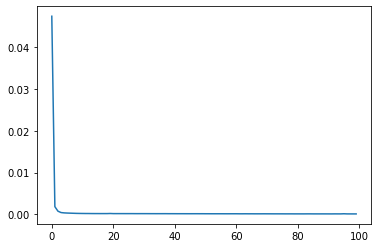

In [30]:
# check if the loss curve is flattened out to see if the neural net is sufficiently trained
plt.plot(history.history['loss'])

## 1st Neural Network Model Performance

In [39]:
predict_1 = model_1.predict(X_test)
predict_1 = scaler.inverse_transform(predict_1)

rmse = np.sqrt(np.mean(predict_1 - y_test)**2)
rmse

3.371237291608538

## 2nd Neural Network with the custom loss function

### Create a custom loss function to add penalty

In [33]:
import keras.losses
import tensorflow as tf

def custom_loss(true_val, predict_val):
    penalty = 500
    loss = tf.where(tf.less(true_val * predict_val, 0), penalty * tf.square(true_val - predict_val), tf.square(true_val - predict_val))
    
    return tf.reduce_mean(loss, axis=-1)

keras.losses.custom_loss = custom_loss

In [36]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

set_seeds()
    
model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(Dropout(0.2)) # add dropout to prevent overfitting
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# fit the neural network model with a custom loss function
model_2.compile(optimizer=optimizer, loss=custom_loss, metrics=['accuracy']) # use the custom loss function instead of sme from the previous model
history = model_2.fit(X_train, y_train, epochs=100, batch_size=30)

Epoch 1/100
2042/2042 [==============================] - 21s 10ms/step - loss: 0.0094 - accuracy: 4.8972e-04
Epoch 2/100
2042/2042 [==============================] - 19s 9ms/step - loss: 2.6896e-04 - accuracy: 4.8972e-04
Epoch 3/100
2042/2042 [==============================] - 20s 10ms/step - loss: 2.4683e-04 - accuracy: 4.8972e-04
Epoch 4/100
2042/2042 [==============================] - 19s 9ms/step - loss: 2.5496e-04 - accuracy: 4.8972e-04
Epoch 5/100
2042/2042 [==============================] - 19s 9ms/step - loss: 2.3861e-04 - accuracy: 4.8972e-04
Epoch 6/100
2042/2042 [==============================] - 18s 9ms/step - loss: 2.3428e-04 - accuracy: 4.8972e-04
Epoch 7/100
2042/2042 [==============================] - 18s 9ms/step - loss: 2.3525e-04 - accuracy: 4.8972e-04
Epoch 8/100
2042/2042 [==============================] - 18s 9ms/step - loss: 2.2835e-04 - accuracy: 4.8972e-04
Epoch 9/100
2042/2042 [==============================] - 18s 9ms/step - loss: 2.2653e-04 - accuracy: 4.897

2042/2042 [==============================] - 18s 9ms/step - loss: 1.5622e-04 - accuracy: 4.8972e-04
Epoch 74/100
2042/2042 [==============================] - 19s 9ms/step - loss: 1.5768e-04 - accuracy: 4.8972e-04
Epoch 75/100
2042/2042 [==============================] - 20s 10ms/step - loss: 1.5229e-04 - accuracy: 4.8972e-04
Epoch 76/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.5358e-04 - accuracy: 4.8972e-04
Epoch 77/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.5648e-04 - accuracy: 4.8972e-04
Epoch 78/100
2042/2042 [==============================] - 18s 9ms/step - loss: 1.4547e-04 - accuracy: 4.8972e-04
Epoch 79/100
2042/2042 [==============================] - 19s 9ms/step - loss: 1.5428e-04 - accuracy: 4.8972e-04
Epoch 80/100
2042/2042 [==============================] - 19s 9ms/step - loss: 1.4894e-04 - accuracy: 4.8972e-04
Epoch 81/100
2042/2042 [==============================] - 19s 9ms/step - loss: 1.4704e-04 - accuracy: 4.8972

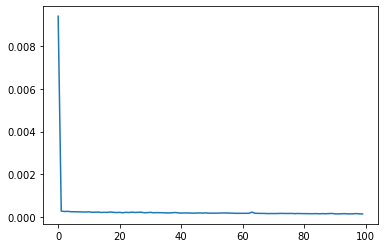

In [37]:
# check if the loss curve is flattened out to see if the neural net is sufficiently trained
plt.plot(history.history['loss'])

## 2nd Neural Network Model Performance

#### The 2nd Neural Network model with a custom loss function performs much better than the 1st neural network model.

In [40]:
predict_2 = model_2.predict(X_test)
predict_2 = scaler.inverse_transform(predict_2)

rmse = np.sqrt(np.mean(predict_2 - y_test)**2)
rmse

0.8854498073032924

## Ensembling 1st and 2nd Neural Network Model

## Ensembling Model Performance

In [42]:
ensembling_predict = np.mean(np.hstack((predict_1, predict_2)), axis=1)

In [44]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(np.mean(ensembling_predict - y_test)**2)
rmse

2.1283434186662946

## Plot the prediction and compare with a Simple Moving Average baseline

Text(0.5, 0, 'Time')

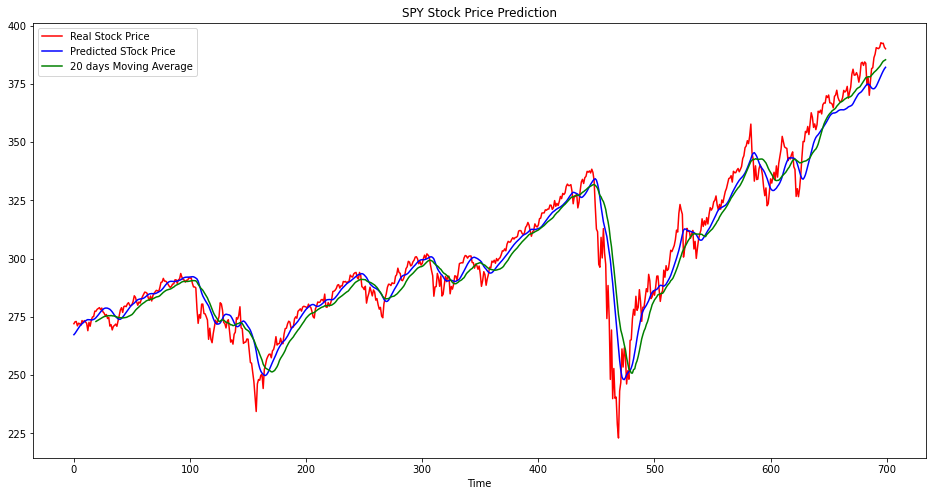

In [92]:
# Visualising the results
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'red', label='Real Stock Price')
plt.plot(predict_2, color = 'blue', label='Predicted STock Price')
plt.plot(pd.DataFrame(y_test).rolling(20).mean(), color = 'green', label='20 days Moving Average')
plt.legend()
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')


#### We can see the 2nd neural network model performs very well with only 0.885 RMSE. It also fits closely to the 20 day Simple Moving Average (SMA).